### 0. Environment Setup

In [2]:
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

### 1. Data Preparation

In [3]:
import data.data_loader as loader

# loader.store_data()

In [4]:
data = loader.data_preprocess()
data.head()

,tags,a_id,q_id,date,link,title,body,view_count,answer,cleaned_text,cleaned_title
77994129,"['nlp', 'label-studio']",NaN,77994129,1707912001,https://stackoverflow.com/questions/77994129/h...,How can I use label studio to annotate text da...,<p>How can I use label studio to annotate text...,725,NaN,use label studio annotate text datum google co...,use label studio annotate text datum google colab
75709831,"['python', 'deep-learning', 'pytorch', 'nlp', ...",NaN,75709831,1678572297,https://stackoverflow.com/questions/75709831/z...,Zero Accuracy in Sentiment Analysis FFNN Model...,<p>I'm constructing a feedforward neural net (...,125,NaN,zero accuracy sentiment analysis ffnn model py...,zero accuracy sentiment analysis ffnn model py...
79485259,"['python', 'nlp', 'spacy']",NaN,79485259,1741138463,https://stackoverflow.com/questions/79485259/s...,Spacy rules matching entities before text,<p>I'm trying to write a spacy parser to extra...,29,NaN,spacy rule match entity text try write spacy p...,spacy rule match entity text
79501178,"['python', 'nlp', 'large-language-model']",79501337.0,79501178,1741704631,https://stackoverflow.com/questions/79501178/s...,Store images instead of showing in a server,<p>I am running the code found on this <a href...,35,<p>I can't test it but ...</p>\n<p>I checked <...,store image instead show server run code find ...,store image instead show server
79548202,"['nlp', 'huggingface-transformers', 'pre-train...",79551169.0,79548202,1743499277,https://stackoverflow.com/questions/79548202/g...,GPT-2 and other models from huggingface -100 l...,<p>I understand the -100 label id is used so t...,43,<p>The author of the tutorial you mentioned se...,model huggingface label index training instead...,model huggingface label index training instead...


### 3. Graphic Representation of the datasets

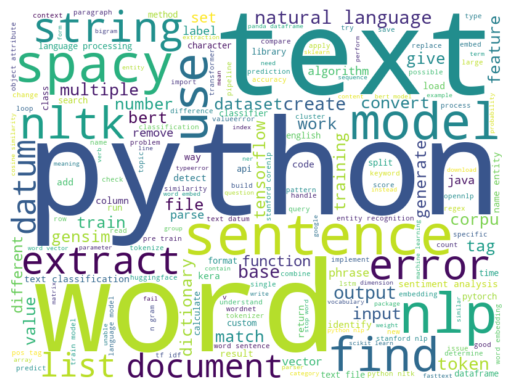

In [5]:
import data.data_analysis as analysis

analysis.word_cloud_for_title(data)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

vectorizer = TfidfVectorizer(max_df=0.85)
tfidf = vectorizer.fit_transform(data['cleaned_title'])

feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_

# create a dictionary mapping each term to its IDF score.
idf_dict = dict(zip(feature_names, idf_scores))

# sort the terms based on the IDF scores (lowest first).
sorted_terms = sorted(idf_dict.items(), key=lambda item: item[1])
#print(sorted_terms)

# for term, score in sorted_terms:
#     if score > 10:
#         print(term, score)

# create custom stop words list to add those terms with low IDF score (threshold < 3.5)
custom_stop_words = []
for term, score in sorted_terms:
    if score <= 3.5:
        custom_stop_words.append(term)

# again perform stop word removal
def custom_stop_word_removal(text):
    tokens = word_tokenize(text)
    text = [word for word in tokens if word.lower() not in custom_stop_words]
    text = " ".join(text)
    return text

data['cleaned_title'] = data['cleaned_title'].apply(custom_stop_word_removal)

In [7]:
updated_text = " ".join(word for word in data['cleaned_title'])
updated_wordc = WordCloud(width = 800, height = 600, background_color='white').generate(updated_text)
plt.figure()
plt.imshow(updated_wordc, interpolation="bilinear")
plt.axis("off")
plt.show()

NameError: name 'WordCloud' is not defined

### 4. Posts Caterogisation


##### **Topic Modelling - Latent Dirichlet Allocation (LDA)**

In [10]:
# LDA topic modelling with count vectors

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# cnovert text into count matrix
LDA_count_vectorizer = CountVectorizer(max_df=0.85) # ignore words appear in >85% of document to eliminate very common words
LDA_count = LDA_count_vectorizer.fit_transform(data['cleaned_text'])

# initialise LDA model to extract 15 topics
lda_count = LatentDirichletAllocation(n_components=15, random_state=42) # ensure reproducibility
lda_count.fit(LDA_count)

# retrieve the list of words in the vobulary
feature_names_count = LDA_count_vectorizer.get_feature_names_out()

# display the top 5 words for each topic
for topic_idx, topic in enumerate(lda_count.components_):
    top_words = [feature_names_count[i] for i in topic.argsort()[-5:]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: nltk, sentence, pos, tag, word
Topic 1: text, line, datum, label, file
Topic 2: gram, vector, similarity, document, feature
Topic 3: dataset, datum, training, train, model
Topic 4: face, huggingface, fine, tokenizer, model
Topic 5: use, text, user, api, question
Topic 6: extract, word, frequency, count, text
Topic 7: embed, vector, input, model, word
Topic 8: want, like, string, list, word
Topic 9: extract, ner, name, spacy, entity
Topic 10: file, dataframe, datum, column, text
Topic 11: matrix, gensim, term, topic, document
Topic 12: noun, stanford, parse, language, sentence
Topic 13: get, run, code, try, error
Topic 14: good, like, text, sentence, word


The LDA with count vector gives us the top five words of each topic as we think displaying the top 5 would be informative enough in providing high-level thematic insights. Since LDA gives different results every time we run, a random seed = 42 is set to ensure the reproducibility of results. For example, words in topic 10 (e.g. file, dataframe, datum, column, text) may be issues related to data reading and formatting. Also, wordings in topic 0 and 9 (e.g. nltk, pos, spacy, ner, entity) are common terms we see in data preprocessing stage. Further, words in topic 3 and 13 (e.g. training, train, try, error) are terms we usually see in Model Training and Testing stage. To conclude, the LDA using bad-of-words model provide certain level of evidence to support the categorisation design of ours.

In [11]:
# LDA topic modelling with TF-IDF

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# convert text into tf-idf matrix
LDA_tf_vectorizer = TfidfVectorizer(max_df=0.85) # ignore words appear >85% in documents to eliminate very common words
LDA_tfidf = LDA_tf_vectorizer.fit_transform(data['cleaned_text'])

# initialise LDA model to extract 15 topics
lda_tf = LatentDirichletAllocation(n_components=15, random_state=42) # ensure reproducibility   
lda_tf.fit(LDA_tfidf)

# retrieve the list of words in the vobulary
feature_names_tf = LDA_tf_vectorizer.get_feature_names_out()

# display the top 5 words for each topic
for topic_idx, topic in enumerate(lda_tf.components_):
    top_words = [feature_names_tf[i] for i in topic.argsort()[-5:]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: install, attributeerror, attribute, import, error
Topic 1: bertopic, lda, coherence, mallet, topic
Topic 2: deberta, smooth, deeppavlov, freqdist, bleu
Topic 3: sgd, acc, singularize, automodelforsequenceclassification, elmo
Topic 4: adapter, dynet, biobert, scispacy, bla
Topic 5: model, run, try, file, error
Topic 6: vbd, dt, jj, nnp, nn
Topic 7: bert, datum, error, train, model
Topic 8: like, list, sentence, text, word
Topic 9: noun, stanford, tag, sentence, entity
Topic 10: hunspell, chocolate, roc, codec, sentiwordnet
Topic 11: tp, tflearn, fn, fp, nmf
Topic 12: onnx, audio, triple, bengali, predicate
Topic 13: seller, deepspeech, synonymous, jwnl, verbnet
Topic 14: senna, subtree, abstractive, meteor, rouge


LDA with TF-IDF does not work well for providing insights on categorization. The TF-IDF weighting tends to emphasize on rare words that might be mispelled and not carrying any useful information, which result in several noisy and fragmented topics (e.g. topic 3 and 6). The topics and wordings are not providing meaningful insights compared to the bag-of-word approach.

##### **Document Clustering - K-means Clustering**


In [12]:
# K-means clustering with tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# convert text into tf-idf matrix
k_vectorizer = TfidfVectorizer(max_df=0.85)  # ignore words appear >85% in documents to reduce very common words
k_tfidf = k_vectorizer.fit_transform(data['cleaned_text'])

# initialise k-means clustering model with specified number of clusters
kmeans = KMeans(n_clusters=15, random_state=42) # ensure reproducibility
kmeans.fit(k_tfidf)

# get feature indices for each cluster center sorted in descending order
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = k_vectorizer.get_feature_names_out()

# display 15 clusters and each with top 5 terms closest to centre
for i in range(15):
    top_terms = [terms[ind] for ind in order_centroids[i, :5]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

Cluster 0: document, similarity, term, topic, word
Cluster 1: language, natural, processing, english, text
Cluster 2: noun, phrase, verb, extract, sentence
Cluster 3: feature, text, word, model, datum
Cluster 4: model, train, training, bert, datum
Cluster 5: column, dataframe, row, panda, text
Cluster 6: entity, name, ner, spacy, recognition
Cluster 7: vector, embed, word, embedding, layer
Cluster 8: word, list, like, text, string
Cluster 9: sentiment, analysis, negative, positive, review
Cluster 10: sentence, word, like, text, list
Cluster 11: error, try, code, get, run
Cluster 12: text, like, want, use, try
Cluster 13: file, text, line, code, python
Cluster 14: tag, pos, tagger, word, nltk


The result present distinct clusters clearly grouping related terms. For instance, clusters related to formatting (e.g. "column, dataframe, row, panda, text"), preprocessing (e.g. "tag, pos, tagger, word, nltk" and "entity, name, ner, spacy, recognition"), feature engineering (e.g. "vector, embed, word, embedding, layer") and model training ("model, train, training, bert, datum" and "sentiment, analysis, negative, positive, review") provide non-overlapping thematic insights to support the categorization pipeline.

In [13]:
# K-means clustering with Word2Vec

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

# tokenise and lowercase column: data['cleaned_text'] and train a Wrod2Vec model on it
tokenized_docs = [word_tokenize(doc.lower()) for doc in data['cleaned_text']]
k_word2vec = Word2Vec(tokenized_docs)

# function to average the word vectors and produce a fixed-length document representation
def compute_doc_vectorise(docs, model):
    doc_embeddings = []
    for tokens in docs:
        # collect vectors for tokens that exist in the model's vocabulary
        vectors = [model.wv[token] for token in tokens if token in model.wv]
        if vectors:
            # compute the mean vector for the document
            avg_vec = np.mean(vectors, axis=0)
        else:
            # return a zero vector if no tokens are found in the vocabulary
            avg_vec = np.zeros(model.vector_size)
        doc_embeddings.append(avg_vec)
    return np.array(doc_embeddings)

vectorized_docs = compute_doc_vectorise(tokenized_docs, model=k_word2vec)

# initialise and fit the k-means clustering model
kmeans_word2vec = KMeans(n_clusters=15)
cluster_labels = kmeans_word2vec.fit(vectorized_docs)

# display 15 clusters and each with top 5 terms
for i in range(15):
    tokens_per_cluster = []
    most_representative = k_word2vec.wv.most_similar(positive=[cluster_labels.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster.append(t[0])
    print(f"Cluster {i}: {', '.join(tokens_per_cluster)}")

Cluster 0: unfortunately, execute, cmd, compile, successfully
Cluster 1: align, embedding, vector, suppose, static
Cluster 2: csv, txt, srt, raw, seperate
Cluster 3: model, finetune, retrain, embeding, distilbert
Cluster 4: deduplicate, numerous, diverse, basically, quiz
Cluster 5: everytime, restore, attempt, initialise, llama
Cluster 6: biomedical, setence, ruler, organisation, entityruler
Cluster 7: parsed, chunk, cfg, treeannotation, tagged
Cluster 8: unseen, smo, informative, classifcation, unlabeled
Cluster 9: df, dataframe, column, append, tokenized
Cluster 10: centroid, distinctive, weightage, dissimilarity, umap
Cluster 11: multiword, counter, substring, jumble, combined
Cluster 12: logit, lora, elmo, prediction, fitting
Cluster 13: following, seperate, put, concordance, inspect
Cluster 14: wordninja, ruby, nodejs, transliteration, offline


The k-means clustering with Word2Vec results show several clusters with ambiguous, unrelated or mixed terms. This is most likely due to the averaging of word embeddings to form document vectors, which dilutes the contextual and semantic signals. These wordings especially adjectives do not directly map to the proposed categorisation pipeline stages. The inconsistency makes it difficult to use the clusters result as a basis for categorisation. 

##### **Topic Labelling - BERTopic**

In [ ]:
# !pip install bertopic
# !pip install tf-keras

In [15]:
# topic Labelling - BERTopic

from bertopic import BERTopic
import warnings
warnings.filterwarnings("ignore")

# create and fit BERTopic model and set the grouping of topics into 15 clusters
topic_model = BERTopic(nr_topics=15)
topics, probs = topic_model.fit_transform(data['cleaned_text'])

# retrieve and display info about the topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9410,-1_word_text_model_sentence,"[word, text, model, sentence, try, like, use, ...",[work python get question gensim documentation...
1,0,4544,0_word_sentence_like_text,"[word, sentence, like, text, find, want, simil...",[optimize search similar sentence try find sim...
2,1,1461,1_model_bert_train_embed,"[model, bert, train, embed, word, vector, embe...",[possible fine tune pretraine word embed model...
3,2,1204,2_topic_cluster_sentiment_lda,"[topic, cluster, sentiment, lda, text, documen...",[understand lda topic modelling topic overlap ...
4,3,936,3_column_dataframe_row_word,"[column, dataframe, row, word, count, panda, l...",[iterate row dataframe return result row colum...
5,4,725,4_pdf_file_list_text,"[pdf, file, list, text, extract, python, code,...",[extract text pdf file build model gensim like...
6,5,700,5_error_model_try_code,"[error, model, try, code, gpu, get, run, shape...",[valueerror error check input expect shape get...
7,6,376,6_stanford_corenlp_opennlp_error,"[stanford, corenlp, opennlp, error, file, java...",[metaclass create public args sutime method de...
8,7,235,7_remove_emoji_word_stopword,"[remove, emoji, word, stopword, stop, characte...",[remove word text file contain character strin...
9,8,183,8_install_spacy_error_import,"[install, spacy, error, import, instal, try, p...",[spacy import error import try import nlp libr...


The BERTopic results inspired a task-based and keyword-based for our sub-categories. For example, a topic with “column, dataframe, row, panda, text” directly inspired the sub-categories of data extraction and format conversion under Data Reading and Formatting stage. Similarly, a topic featuring “parser, pos, tag, nltk” inspired our Data Preprocessing sub-categories by emphasizing tokenization and linguistic analysis. Moreover, clusters showing terms like “tfidf, matrix, term, document” and “vector, embed, similarity” validated our Feature Engineering sub-categories, while topics with “model, train, bert” informed our Model Training/Testing and "perplexity, bleu, calculate, precision" informed Performance Evaluation sub-categories. These focused clusters clearly reflect real-world issues, providing solid, data-driven inspiration for our task-based categorization pipeline.

Topic -1 is usually assumed to be irrelevant as they cannot clearly fit into any of the main topic clusters. Yet, the large number of count of topic -1, 0, 1 may potentially mask hidden sub-themes. Thus a more detailed investigation on these three topics will be performed using BERTopic to see if more insights can be obtained.

In [16]:
# dig deeper into topic -1 (outliers group)

# extract documents that were assigned to topic -1
subset_topic_negative_1 = [doc for doc, topic in zip(data['cleaned_text'], topics) if topic == -1]

# create new BERTopic model to analyse the group and set the grouping of topics to 10 clusters
subset_negative_1_topic_model = BERTopic(nr_topics=10)
subset_topics_negative_1, subset_probs_negative_1 = subset_negative_1_topic_model.fit_transform(subset_topic_negative_1)

# retrieve and display info about the topics
subset_negative_1_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5739,-1_word_text_sentence_model,"[word, text, sentence, model, like, try, want,...",[datum structure algorithm stream datum identi...
1,0,1793,0_word_sentence_like_text,"[word, sentence, like, text, use, want, spacy,...",[python select sentence base give word export ...
2,1,846,1_error_try_run_code,"[error, try, run, code, spacy, file, python, f...",[install spacy library error try day install s...
3,2,442,2_model_layer_train_loss,"[model, layer, train, loss, label, input, outp...",[keras model learn train train keras model sen...
4,3,346,3_dataframe_column_text_row,"[dataframe, column, text, row, word, datum, pa...",[spacy doc object dataframe column spacy get d...
5,4,137,4_embedding_bert_embed_tokenizer,"[embedding, bert, embed, tokenizer, token, wor...",[split sentence word bert tokenizer try locali...
6,5,45,5_memory_error_gb_try,"[memory, error, gb, try, datum, tagger, run, p...",[process quanteda object large available memor...
7,6,36,6_search_query_solr_product,"[search, query, solr, product, user, filter, r...",[search understand essence query website categ...
8,7,14,7_file_folder_text_subfolder,"[file, folder, text, subfolder, output, code, ...",[extract text multiple file save seperate txt ...
9,8,12,8_maltparser_parse_java_parser,"[maltparser, parse, java, parser, servlet, pro...",[parse raw text maltparser java find nlkt pyth...


Some of the topics after zooming into the outlier group -1 are similar to the main BERTopic analysis. The topics in the group contain mix of generic and noisy terms that do not deliver clear and coherant themes that give inspirations to the sub-categories. To conclude, the overall BERTopic analysis of this group do not provide valuable insights.

In [17]:
# dig deeper into topic 0

# extract documents that were assigned to topic 0
subset_topic_0 = [doc for doc, topic in zip(data['cleaned_text'], topics) if topic == 0]

# create new BERTopic model to analyse the group and set the grouping of topics to 10 clusters
subset_0_topic_model = BERTopic(nr_topics=10)
subset_topics_0, subset_probs_0 = subset_0_topic_model.fit_transform(subset_topic_0)

# retrieve and display info about the topics
subset_0_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,271,-1_sentence_word_regex_text,"[sentence, word, regex, text, like, string, sp...",[splitting tokenize sentence string word speci...
1,0,2990,0_word_sentence_like_text,"[word, sentence, like, text, similarity, find,...",[algorithm sue match sentence let list sentenc...
2,1,448,1_intent_chatbot_bot_user,"[intent, chatbot, bot, user, dialogflow, entit...",[train bot intent user phrase know train dialo...
3,2,219,2_model_spacy_train_ner,"[model, spacy, train, ner, entity, training, c...",[create custom ner spacy want train additional...
4,3,202,3_bigram_file_memory_process,"[bigram, file, memory, process, code, list, ru...",[improve spacy memory usage run time run docum...
5,4,166,4_language_arabic_translate_english,"[language, arabic, translate, english, transla...",[corenlp language like arabic corenlp successf...
6,5,100,5_regex_word_match_text,"[regex, word, match, text, string, expression,...",[pattern extract regex python try use regex wo...
7,6,91,6_lucene_search_elasticsearch_index,"[lucene, search, elasticsearch, index, query, ...",[approach suggestiosn classify keyword search ...
8,7,45,7_plural_singular_gender_noun,"[plural, singular, gender, noun, male, form, w...",[convert plural noun singular nlp list plural ...
9,8,12,8_ingredient_recipe_food_measurement,"[ingredient, recipe, food, measurement, butter...",[natural language processing php give recipe l...


The dive into the topic 0 of the entire BERtopic analysis gives a bit of interesting insights of the sub-categories design and support of the structure of the categorisation pipeline. The topic 2 ("spacy, ner") is clearly something in data preprocessing stage and NER can be regarded as a task-based or keywords-based sub-category. In addition, wordings in topic 5 ("regex, match") gives inspiration of creating one sub-category under data preprocessing of Regex. Topic 7 wordings are something we can address using lemmatization/stemming sub-category, supporting the necessity of this sub-category.

In [19]:
# dig deeper into topic 1

# extract documents that were assigned to topic 1
subset_topic_1 = [doc for doc, topic in zip(data['cleaned_text'], topics) if topic == 1]

# create new BERTopic model to analyse the group and set the grouping of topics to 10 clusters
subset_1_topic_model = BERTopic(nr_topics=10)
subset_topics_1, subset_probs_1 = subset_1_topic_model.fit_transform(subset_topic_1)

# retrieve and display info about the topics
subset_1_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,96,-1_model_datum_dataset_training,"[model, datum, dataset, training, code, input,...",[weird result test token classification model ...
1,0,635,0_word_vector_embed_model,"[word, vector, embed, model, sentence, embeddi...",[good way handle miss word word embedding set ...
2,1,467,1_bert_model_sentence_error,"[bert, model, sentence, error, fine, use, try,...",[way use bert large text classification tool f...
3,2,110,2_model_transformer_train_training,"[model, transformer, train, training, fine, da...",[hug face model pre trained train want use hug...
4,3,39,3_tokenizer_token_huggingface_special,"[tokenizer, token, huggingface, special, add, ...",[add token bpe tokenizer want add new word bpe...
5,4,30,4_stanford_ner_crf_mallet,"[stanford, ner, crf, mallet, file, feature, tr...",[use pos tag feature stanford ner training try...
6,5,24,5_tensor_tensorflow_shape_cosine,"[tensor, tensorflow, shape, cosine, similarity...",[tensorflow customizingly gather split tensor ...
7,6,22,6_attention_head_self_layer,"[attention, head, self, layer, shape, matrix, ...",[attention tensor shape meaning try extract at...
8,7,21,7_loss_epoch_training_model,"[loss, epoch, training, model, accuracy, value...",[training validation loss suddenly increase po...
9,8,17,8_checkpoint_save_model_training,"[checkpoint, save, model, training, continue, ...",[checkpoint albert file change train train alb...


Most of the topics after digging deep into topic 1 from the entire BERTopic analysis inspires mostly the sub-categories in Model Training and Testing stage. Topic 2, 7 and 8 featuring keywords like "transformer, train, loss, epoch, checkpoint, save" stimulate the Model Training and Fine-tuning sub-category as they are common terms when we train on NLP models.